# Introduction

* This notebook aims to use a simple LTSpice simulation of a series RLC circuit;
* The input voltage signals are generated using numpy;
* The PyLTSpice package is used to control and process the data from the simulation.

### Generating base signals 

In [170]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from quantiphy import Quantity #to format numbers 

### Generating the sinc function in time domain
* Given a bandwidth and a sampling rate, create a sinc pulse  $p(t)$ in the time domain;
* This pulse will be used to modulate a data given a certain modulation scheme.

The equation of the sinc function is:

$p(t) =  sinc \left ( 2Bt \right )$

Where:
- B is the bandwidth in Hz;
- $sinc$ in numpy refers to $sinc(t) = \frac{\sin(\pi t) }{ \pi t}$

In the frequecy domain, the sinc signal $p(t)$ transforms into as a rectangular spectrum, defined by the following equation:

$\chi \{ p(t) \} = rect \left ( \dfrac{\omega}{B} \right ) $

Where:
* $\chi \{ \}$ stands for the Fourier Transform operation;
* $rect$ stands for the rectangular pulse function.

The $rect$ function is described by the following expression:

$rect \left ( \dfrac{\omega}{B}\right ) =  \begin{cases}1 & -B/2 \geq \omega \geq B/2 \\
0 & \mathrm{otherwise} \\
\end{cases}$



In [171]:
#initial parameters
t_init = 0 #initial time array
t_end = 1e-3 #end of time array
numPoints = 10000 #points per pulse
t_step = t_end/numPoints #time step
f_sampling = 1/t_step #equivalent sampling frequency
bw_Hz = 50e3 #bandwidth of signal in Hz 

#time vector
time = np.linspace(t_init,t_end,numPoints)
t_disp = time.item(round(numPoints/2)) #time displacement of sinc pulse


print("BASIC TIME DATA FOR SINC PULSE")
print("Time step:")
print(Quantity(t_step,'s'))
print("Sampling Frequency: ")
print(Quantity(f_sampling,'Hz'))
print("Length of time vector:")
print(time.size)
print("Bandwidth of signal:")
print(Quantity(bw_Hz,'Hz'))
print("Time displacement:")
print(Quantity(t_disp,'s'))


BASIC TIME DATA FOR SINC PULSE
Time step:
100 ns
Sampling Frequency: 
10 MHz
Length of time vector:
10000
Bandwidth of signal:
50 kHz
Time displacement:
500.05 us


### Plot of sinc pulse in time domain

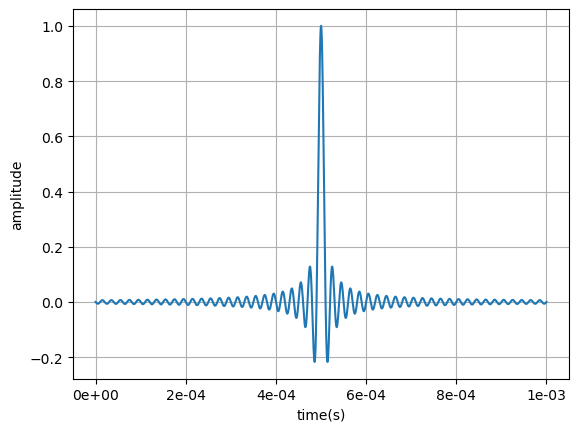

In [172]:
vsinc = np.sinc((2*bw_Hz)*(time-t_disp))

plt.plot(time,vsinc)
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlabel("time(s)")
plt.ylabel("amplitude")
plt.grid()

### FFT Parameters 

In [173]:
#parameters for FFT
count = len(vsinc)
values = np.arange(int(count/2))
time_period = count/f_sampling
frequencies = values/time_period

print("FFT PARAMETERS")
print("Length of sinal (must be the equals numPoints):")
print(count)
print("Sample of the frequency components:")
print(values[:10])
print("FFT time window length:")
print(Quantity(time_period,'s'))
print("Sample of the array of frequencies (Hz):")
print(frequencies[:10])
print("Length of frequencies array:")
print(len(frequencies))

FFT PARAMETERS
Length of sinal (must be the equals numPoints):
10000
Sample of the frequency components:
[0 1 2 3 4 5 6 7 8 9]
FFT time window length:
1 ms
Sample of the array of frequencies (Hz):
[   0. 1000. 2000. 3000. 4000. 5000. 6000. 7000. 8000. 9000.]
Length of frequencies array:
5000


### FFT Plot

(0.0, 100000.0)

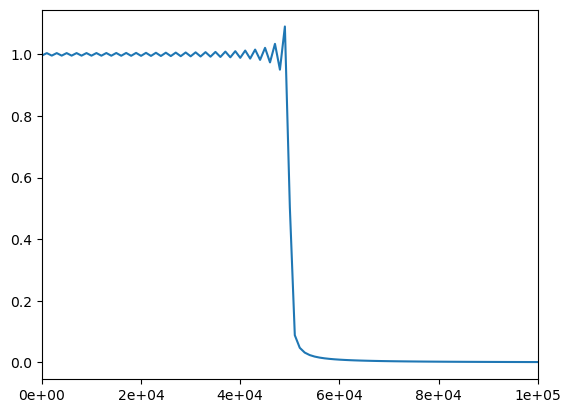

In [177]:
vsinc_fft = np.fft.fft(vsinc, norm="ortho") #scales the fft by 1/sqrt(N), where N is the lenght of signal
frequencies = np.fft.fftfreq(vsinc.size,1/f_sampling)

plt.plot(frequencies[:int(frequencies.size/2)],abs(vsinc_fft[:int(frequencies.size/2)]))
plt.gca().xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) #formats time axis to scientific notation
plt.xlim([0,2*bw_Hz])